In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



In [2]:
def preprocess_audio_files(input_folder, output_folder):
    genres = os.listdir(input_folder)
    
    for genre in genres:
        print(f"Processing {genre}...")
        genre_folder = os.path.join(input_folder, genre)
        image_output_folder = os.path.join(output_folder, genre)
        Path(image_output_folder).mkdir(parents=True, exist_ok=True)
        
        for file in os.listdir(genre_folder):
            file_path = os.path.join(genre_folder, file)
            y, sr = librosa.load(file_path, sr=None, mono=True)

            # Melspectrogram
            mels = librosa.feature.melspectrogram(y=y, sr=sr)

            mels_db = librosa.power_to_db(mels, ref=np.max)
            
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mels_db, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
            plt.colorbar(format='%+2.0f dB')
            plt.title('Mel-frequency spectrogram')
            plt.savefig(os.path.join(image_output_folder, f"{file[:-4]}_mels.png"))
            plt.close()
            
            # MFCC
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mfcc, x_axis='time')
            plt.colorbar()
            plt.title('MFCC')
            plt.savefig(os.path.join(image_output_folder, f"{file[:-4]}_mfcc.png"))
            plt.close()
            
preprocess_audio_files("genres_original", "my_image")

In [3]:
def preprocess_audio_files1(input_folder, output_folder):
    genres = os.listdir(input_folder)
    
    for genre in genres:
        print(f"Processing {genre}...")
        genre_folder = os.path.join(input_folder, genre)
        image_output_folder = os.path.join(output_folder, genre)
        Path(image_output_folder).mkdir(parents=True, exist_ok=True)
        
        for file in os.listdir(genre_folder):
            file_path = os.path.join(genre_folder, file)
            y, sr = librosa.load(file_path, sr=None, mono=True)
            
            # STFT
            stft = librosa.stft(y)
            stft_db = librosa.amplitude_to_db(abs(stft))
            
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='log')
            plt.colorbar(format='%+2.0f dB')
            plt.title('Short-Time Fourier Transform (STFT)')
            plt.savefig(os.path.join(image_output_folder, f"{file[:-4]}_stft.png"))
            plt.close()
            
            # Zero-crossing rate
            zcr = librosa.feature.zero_crossing_rate(y)
            
            plt.figure(figsize=(10, 4))
            plt.plot(zcr[0])
            plt.title('Zero-Crossing Rate')
            plt.savefig(os.path.join(image_output_folder, f"{file[:-4]}_zcr.png"))
            plt.close()
            
            # Harmonic components
            y_harmonic, y_percussive = librosa.effects.hpss(y)
            
            plt.figure(figsize=(10, 4))
            librosa.display.waveshow(y_harmonic, sr=sr, alpha=0.25)

            plt.title('Harmonic Components')
            plt.savefig(os.path.join(image_output_folder, f"{file[:-4]}_harmonic.png"))
            plt.close()

preprocess_audio_files("genres_original", "my_image")

In [4]:

# Dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder("my_image", transform=transform)

# Train-Validation-Test split
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


In [5]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device,model_filename):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels.data)

        epoch_loss = train_loss / len(train_dataset)
        epoch_acc = train_corrects.double() / len(train_dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())

        model.eval()
        val_loss = 0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = val_loss / len(val_dataset)
        epoch_val_acc = val_corrects.double() / len(val_dataset)
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc.item())

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}")

        torch.save(model.state_dict(), model_filename)
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

def plot_history(train_loss, train_acc, val_loss, val_acc):
    plt.figure()
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(train_acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


Epoch 1/50, Loss: 2.2587, Accuracy: 0.1245, Validation Loss: 2.1940, Validation Accuracy: 0.1739
Epoch 2/50, Loss: 2.1113, Accuracy: 0.2024, Validation Loss: 2.0317, Validation Accuracy: 0.3545
Epoch 3/50, Loss: 1.9385, Accuracy: 0.3026, Validation Loss: 1.8722, Validation Accuracy: 0.3813
Epoch 4/50, Loss: 1.8046, Accuracy: 0.3519, Validation Loss: 1.7847, Validation Accuracy: 0.3579
Epoch 5/50, Loss: 1.7012, Accuracy: 0.3884, Validation Loss: 1.6738, Validation Accuracy: 0.4047
Epoch 6/50, Loss: 1.5932, Accuracy: 0.4106, Validation Loss: 1.6481, Validation Accuracy: 0.3913
Epoch 7/50, Loss: 1.5285, Accuracy: 0.4371, Validation Loss: 1.5682, Validation Accuracy: 0.4214
Epoch 8/50, Loss: 1.4495, Accuracy: 0.4757, Validation Loss: 1.4888, Validation Accuracy: 0.4682
Epoch 9/50, Loss: 1.4373, Accuracy: 0.4700, Validation Loss: 1.4929, Validation Accuracy: 0.4381
Epoch 10/50, Loss: 1.3594, Accuracy: 0.5007, Validation Loss: 1.5648, Validation Accuracy: 0.4682
Epoch 11/50, Loss: 1.3097, Ac

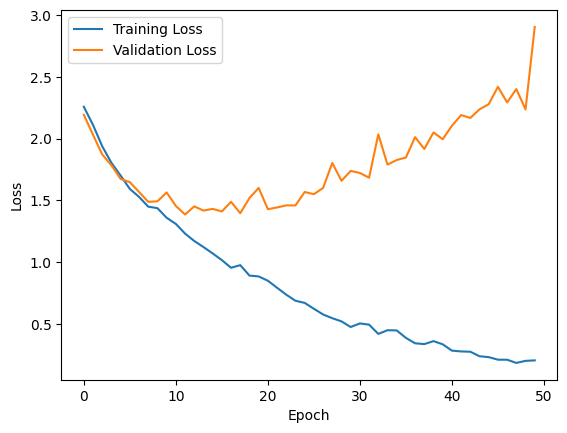

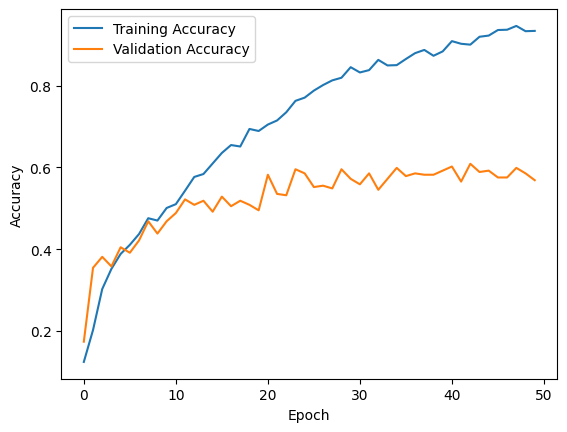

In [7]:

class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MusicGenreCNN()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device,"MusicGenreCNN.pth")
plot_history(train_loss, train_acc, val_loss, val_acc)


In [7]:
preprocess_audio_files("my music", "my_test")
preprocess_audio_files1("my music", "my_test")

Processing hiphop...
Processing hiphop...


In [8]:
from torch.utils.data import Dataset
from PIL import Image

class SongImagesDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image


In [9]:
model = CNNModel(num_classes=10)
model.load_state_dict(torch.load("MusicGenreCNN.pth"))
model = model.to(device) 
model.eval()


CNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [10]:

input_dir = "D:/final/my_test/王位"
input_images = [os.path.join(input_dir, img) for img in os.listdir(input_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

input_dataset = SongImagesDataset(input_images, transform=transform)
input_loader = DataLoader(input_dataset, batch_size=1, shuffle=False)


In [12]:
# Map the indices to genres
idx_to_genre = {
    0: "blues",
    1: "classical",
    2: "country",
    3: "disco",
    4: "hiphop",
    5: "jazz",
    6: "metal",
    7: "pop",
    8: "reggae",
    9: "rock"
}

# Perform prediction and compute probabilities
with torch.no_grad():
    predictions = []
    for image in input_loader:
        image = image.to(device)
        output = model(image)
        softmax_output = torch.softmax(output, dim=1).cpu().numpy()
        predictions.append(softmax_output)

# Average the probabilities across the 5 input images
average_prediction = np.mean(predictions, axis=0)

# Sort the genres by probability
sorted_genres = sorted(zip(idx_to_genre.values(), average_prediction[0]), key=lambda x: x[1], reverse=True)

#print name
folder_path = r"D:\final\my_test\王位"
file_list = os.listdir(folder_path)

if file_list:
    first_file_name = file_list[0]
    print("The first file in the folder is:", first_file_name)
else:
    print("The folder is empty")

# Print the results
for genre, probability in sorted_genres:
    print(f"{genre}: {probability * 100:.2f}%")


The first file in the folder is: 王位-杨和苏KeyNG_harmonic.png
reggae: 58.42%
blues: 12.59%
rock: 9.92%
country: 9.84%
jazz: 4.62%
classical: 3.27%
hiphop: 0.63%
disco: 0.37%
pop: 0.26%
metal: 0.08%
